#**Avance 2. Ingeniería de Características**

###**Maestría en Inteligencia Artificial Aplicada**
###**Curso: Administración del Desarrollo de Software**
###**Tecnológico de Monterrey**
###**Prof. Mtro. Gilberto Carlo Grajales Aranao**

###**Equipo 1**

####**A01795313 – Karla Alejandra Fonseca Márquez**
####**A01795315 – Julia Gabriela Pinedo**
####**A01795838 – Javier Augusto Rebull Saucedo**
####**A00439670 – Ignacio Sáyago Vela**

**INTRODUCCIÓN**


En este documento se lleva a cabo la ingeniería de características para la funcionalidad del sistema por desarollar, que pretende determinar la probabilidad de que sea otorgada una visa de trabajo en Estados Unidos al usuario con base en los datos que proporcione.

Para ello se trabajó en el análisis exploratorio de datos utilizando una base de datos obtenida en la página de Kaggle, que contiene 25480 registros de aplicaciones para visa de trabajo en Estados Unidos, con diferentes atributos tanto del empleador como del empleado (https://www.kaggle.com/datasets/moro23/easyvisa-dataset/data).

#**ACTUALIZAR DESDE AQUÍ...A partir de este análisis, se eliminaron algunas variables que contenían información duplicada, se imputaron valores faltantes, se analizaron las variables numéricas y categóricas binarias, nominales y ordinales. Asimismo se detectó que existe un desbalanceo de clases en la variable dependiente, y se aplicaron las transformaciones y escalamientos necesarios para normalizar los datos y procurar que tuvieran una distribución más aproximada a una gaussiana. Finalmente se crearon los conjutnos de entrenamiento, validación y prueba.**

A continuación, se procederá a explorar métodos de filtrado para la selección de características que permita reducir los requerimientos de almacenamiento, la complejidad del modelo y el tiempo de entrenamiento.

Cabe mencionar que para las otras funcionalidades del sistema no se requiere llevar a cabo un análisis exploratorio de datos puesto que se emplearán técnicas de deep learning y visión computacional, utilizando conjuntos de datos que constan de imágenes que ya han sido preprocesadas.    


**IMPORTACIÓN DE LIBRERÍAS**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from tabulate import tabulate

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor

##**1) Carga de los dataframes generados en el Análisis Exploratorio de Datos**

In [1]:
# Se carga el archivo ZIP que contiene los dataframes generados en la actividad anterior

!unzip /content/my_data.zip


Archive:  /content/my_data.zip
 extracting: content/Dataset_VPAI/df.pkl  
 extracting: content/Dataset_VPAI/XtrainT.pkl  
 extracting: content/Dataset_VPAI/XvalT.pkl  
 extracting: content/Dataset_VPAI/XtestT.pkl  
 extracting: content/Dataset_VPAI/ytrainT.pkl  
 extracting: content/Dataset_VPAI/yvalT.pkl  
 extracting: content/Dataset_VPAI/ytestT.pkl  


In [4]:
# Se crean los dataframes vacíos

df_names = ['df','XtrainT','XvalT', 'XtestT', 'ytrainT', 'yvalT', 'ytestT']

for df_name in df_names:
  globals()[df_name] = pd.DataFrame()


In [5]:
# Se cargan los archivos Pickle en sus respectivos dataframes

import pickle

path = '/content/content/Dataset_VPAI/'

df_list = [df, XtrainT, XvalT, XtestT, ytrainT, yvalT, ytestT]


if len(df_names) == len(df_list):
  for i, df_name in enumerate(df_names):
    with open(path + df_name + '.pkl', 'rb') as file:

        if df_name == 'df':
          df = pickle.load(file)
        if df_name == 'XtrainT':
          XtrainT = pickle.load(file)
        if df_name == 'XvalT':
          XvalT = pickle.load(file)
        if df_name == 'XtestT':
          XtestT = pickle.load(file)
        if df_name == 'ytrainT':
          ytrainT = pickle.load(file)
        if df_name == 'yvalT':
          yvalT = pickle.load(file)
        if df_name == 'ytestT':
          ytestT = pickle.load(file)


In [6]:
display(df.head(5))
display(XtrainT.head(5))
display(XvalT.head(5))
display(XtestT.head(5))
display(ytrainT.head(5))
display(yvalT.head(5))
display(ytestT.head(5))


,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,unit_of_wage,full_time_position,case_status,wage_range,no_of_employees_range,yr_of_estab_range
0,Asia,High School,N,N,14513,2007,West,Hour,Y,Denied,> 100000,> 3450,> 2002
1,Asia,Master's,Y,N,2412,2002,Northeast,Year,Y,Certified,50000-100000,2300-3450,> 2002
2,Asia,Bachelor's,N,Y,44444,2008,West,Year,Y,Denied,> 100000,> 3450,> 2002
3,Asia,Bachelor's,N,N,98,1897,West,Year,Y,Denied,50000-100000,< 1150,< 1987
4,Africa,Master's,Y,N,1082,2005,South,Year,Y,Certified,> 100000,< 1150,> 2002


,education_of_employee,has_job_experience,requires_job_training,full_time_position,wage_range,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,...,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002
9036,0.458579,0,0,1,1.000000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
21818,0.458579,0,0,1,0.000000,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
18343,1.000000,1,1,1,1.000000,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,1
12820,0.458579,0,1,1,0.486565,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
21719,0.458579,1,0,1,0.486565,1,0,0,0,0,...,1,0,0,1,0,0,0,1,0,1


,education_of_employee,has_job_experience,requires_job_training,full_time_position,wage_range,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,...,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002
18754,0.458579,0,0,1,0.486565,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
5834,1.000000,1,0,1,1.000000,1,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
6962,0.556686,0,0,1,0.486565,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
19174,0.458579,0,0,1,0.486565,1,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1
21977,0.556686,1,0,1,0.486565,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


,education_of_employee,has_job_experience,requires_job_training,full_time_position,wage_range,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,...,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002
755,0.000000,1,0,1,0.0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
22508,0.458579,0,0,1,1.0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
483,1.000000,1,0,1,0.0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,1
1724,0.458579,0,1,1,0.0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
14084,0.556686,0,0,1,0.0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


,case_status
9036,0
21818,0
18343,0
12820,0
21719,1


,case_status
18754,1
5834,0
6962,1
19174,0
21977,0


,case_status
755,1
22508,1
483,0
1724,1
14084,1


#**PARTE 1: Análisis PCA**



In [7]:
total_components = XtrainT.shape[1]
print("El número total de componentes es: ", total_components)

El número total de componentes es:  22


In [8]:
# Se realiza el PCA empleando el conjunto de entrenamiento transformado

pca = PCA()
x_projected = pca.fit_transform(XtrainT)
x_projected = pd.DataFrame(x_projected)
x_projected.head(5)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.190871,0.011752,0.370129,1.325080,-0.189010,-0.261561,-0.245729,-0.033415,0.472959,0.057611,...,-0.627979,-0.208954,0.266877,0.041038,0.193431,0.259498,-0.171224,-0.323868,-0.133292,-0.021311
1,-0.118895,0.218868,0.720158,0.382180,0.029016,-0.401144,-0.049445,-0.533050,-0.465561,-0.271755,...,0.026989,0.002030,-0.468785,-0.045225,-0.014140,0.002106,0.016964,0.001809,0.004003,0.002566
2,0.023143,-1.289973,-0.486447,-0.081035,0.363480,0.044590,0.926966,-0.062215,0.154244,1.102159,...,0.350802,-0.202271,0.297645,0.435388,-0.092105,-0.023508,-0.010833,0.005742,0.005867,-0.002807
3,-0.630952,-0.196103,-0.638875,0.656322,0.922708,-0.133453,-0.308456,-0.547820,0.067148,0.139318,...,0.651111,-0.104911,0.211496,-0.025317,-0.040191,0.000282,0.008101,-0.005826,0.000315,0.001278
4,-0.844788,-0.164614,-0.186293,-0.903133,-0.598792,0.100069,-0.457456,-0.150755,0.007534,-0.017581,...,-0.094266,0.189544,0.092131,0.013274,-0.001740,-0.005154,-0.000259,-0.000259,0.006344,-0.001541


In [9]:
print("Los eigen valores para la matriz de covarianza de nuestro conjunto de entrenamiento son:")

e_vals = list(np.round(pca.explained_variance_, decimals=5))

print(e_vals)

Los eigen valores para la matriz de covarianza de nuestro conjunto de entrenamiento son:
[np.float64(0.35196), np.float64(0.32728), np.float64(0.27984), np.float64(0.27142), np.float64(0.25966), np.float64(0.24343), np.float64(0.22116), np.float64(0.18553), np.float64(0.1613), np.float64(0.13339), np.float64(0.10825), np.float64(0.0997), np.float64(0.09657), np.float64(0.06741), np.float64(0.06299), np.float64(0.05448), np.float64(0.04232), np.float64(0.01023), np.float64(0.00964), np.float64(0.00357), np.float64(0.00352), np.float64(0.00306)]


In [10]:
for i in range(0, total_components):
  print("El porcentaje de varianza explicado por el componente principal ", i+1, "es", format(pca.explained_variance_ratio_[i]*100,'.0f'),'%')

El porcentaje de varianza explicado por el componente principal  1 es 12 %
El porcentaje de varianza explicado por el componente principal  2 es 11 %
El porcentaje de varianza explicado por el componente principal  3 es 9 %
El porcentaje de varianza explicado por el componente principal  4 es 9 %
El porcentaje de varianza explicado por el componente principal  5 es 9 %
El porcentaje de varianza explicado por el componente principal  6 es 8 %
El porcentaje de varianza explicado por el componente principal  7 es 7 %
El porcentaje de varianza explicado por el componente principal  8 es 6 %
El porcentaje de varianza explicado por el componente principal  9 es 5 %
El porcentaje de varianza explicado por el componente principal  10 es 4 %
El porcentaje de varianza explicado por el componente principal  11 es 4 %
El porcentaje de varianza explicado por el componente principal  12 es 3 %
El porcentaje de varianza explicado por el componente principal  13 es 3 %
El porcentaje de varianza explic

In [11]:
#Se visualiza la suma acumulada de porcentajes para ver con cuántas características principales se obtiene el 95% de la varianza

np.cumsum(pca.explained_variance_ratio_)

array([0.11744855, 0.22666235, 0.32004402, 0.41061679, 0.49726654,
       0.57849774, 0.65230006, 0.71421224, 0.76803955, 0.81255331,
       0.8486764 , 0.88194745, 0.91417322, 0.93666805, 0.95768738,
       0.97586585, 0.98998731, 0.99340031, 0.9966159 , 0.99780572,
       0.99897868, 1.        ])

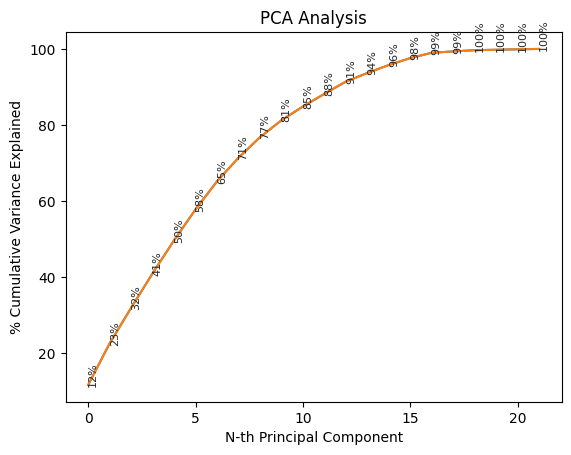

In [12]:
labels = np.cumsum(pca.explained_variance_ratio_)

cum_sum_frac = np.cumsum(pca.explained_variance_ratio_)
cum_sum_per =  [i* 100 for i in cum_sum_frac]
sns.lineplot(data=cum_sum_per)
sns.set_style("darkgrid")
plt.title('PCA Analysis')
plt.xlabel('N-th Principal Component')
import matplotlib.pyplot as plt
labels = np.cumsum(pca.explained_variance_ratio_)

cum_sum_frac = np.cumsum(pca.explained_variance_ratio_)
cum_sum_per =  [i* 100 for i in cum_sum_frac]
sns.lineplot(data=cum_sum_per)
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (20,3)
plt.title('PCA Analysis')
plt.xlabel('N-th Principal Component')
plt.ylabel('% Cumulative Variance Explained')
for i in range(total_components):
  plt.text(i,labels[i]*100,rotation=90,fontsize=8,s=str(format(labels[i]*100,'.0f'))+'%')

#**Podemos ver que las primeras 15 características conforman el 95% de la varianza**

In [13]:
# Se crea un dataframe seleccionando el número de componenetes que explica la mayor parte de la varianza
num_components = 15
pc_df = pd.DataFrame(abs(pca.components_[:num_components]), columns = XtrainT.columns, index=['Principal component {}'.format(i) for i in range(1, num_components + 1)])
pc_df

,education_of_employee,has_job_experience,requires_job_training,full_time_position,wage_range,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,...,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002
Principal component 1,0.028774,0.016334,0.027480,0.030291,0.097185,0.418558,0.227717,0.138476,0.005908,0.028891,...,0.046381,0.113603,0.034746,0.093441,0.170740,0.000478,0.006805,0.036173,0.588096,0.580466
Principal component 2,0.044766,0.137965,0.013690,0.046889,0.179474,0.568729,0.308578,0.200834,0.006573,0.031653,...,0.163516,0.137201,0.035374,0.182917,0.286049,0.000561,0.000174,0.032453,0.385357,0.387618
Principal component 3,0.003987,0.140792,0.121777,0.023535,0.005930,0.124541,0.127989,0.005439,0.002186,0.007169,...,0.210970,0.013310,0.723736,0.497491,0.239958,0.000362,0.002777,0.017020,0.026558,0.034101
Principal component 4,0.009481,0.371337,0.042410,0.019249,0.026740,0.217118,0.090936,0.088042,0.003516,0.025504,...,0.499988,0.001678,0.316067,0.178550,0.139220,0.001293,0.003033,0.092653,0.076110,0.067619
Principal component 5,0.006583,0.144411,0.016085,0.041386,0.029152,0.268536,0.080151,0.155410,0.002563,0.020543,...,0.065135,0.170471,0.201690,0.613431,0.644049,0.000975,0.004803,0.049201,0.013573,0.020705
Principal component 6,0.009609,0.853330,0.083452,0.067374,0.128578,0.068138,0.008298,0.051202,0.002544,0.006078,...,0.207861,0.060173,0.012289,0.023180,0.073116,0.000085,0.003873,0.062805,0.039528,0.046226
Principal component 7,0.001488,0.129217,0.014346,0.004456,0.041925,0.038053,0.012617,0.040373,0.000364,0.008928,...,0.550599,0.014238,0.003988,0.022381,0.010664,0.000785,0.003972,0.014819,0.008841,0.011364
Principal component 8,0.016349,0.139846,0.137959,0.081690,0.286245,0.266438,0.002866,0.231226,0.005150,0.014868,...,0.044013,0.739615,0.262465,0.202651,0.286235,0.000967,0.001410,0.061385,0.029396,0.000655
Principal component 9,0.034503,0.089952,0.061321,0.250639,0.688367,0.069780,0.319332,0.374672,0.003143,0.004205,...,0.019002,0.339058,0.045064,0.045327,0.239522,0.002868,0.018916,0.144677,0.010545,0.028942
Principal component 10,0.055203,0.090171,0.306196,0.011640,0.569234,0.013552,0.512721,0.491306,0.000492,0.012102,...,0.012170,0.032722,0.100392,0.022442,0.042041,0.008188,0.027281,0.226063,0.007721,0.002303


¿Cuáles son las variables más importantes en el cálculo del primer componente?


In [14]:
pc_df.head(1)

,education_of_employee,has_job_experience,requires_job_training,full_time_position,wage_range,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,...,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002
Principal component 1,0.028774,0.016334,0.02748,0.030291,0.097185,0.418558,0.227717,0.138476,0.005908,0.028891,...,0.046381,0.113603,0.034746,0.093441,0.17074,0.000478,0.006805,0.036173,0.588096,0.580466


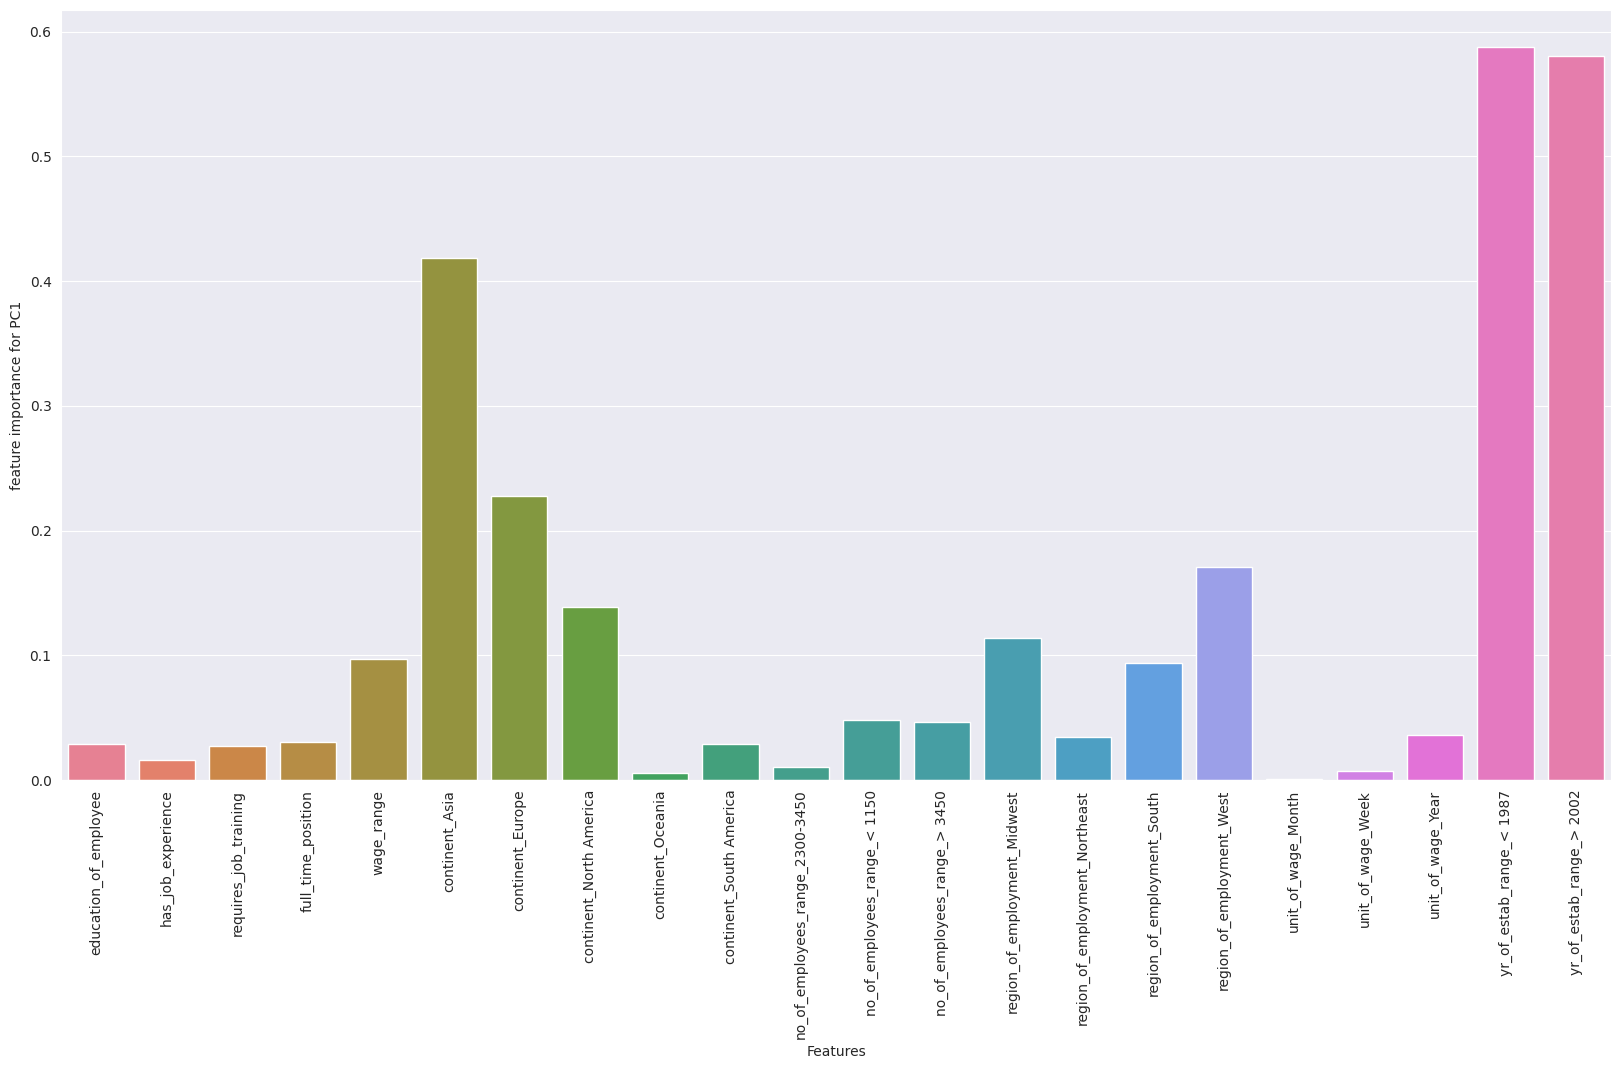

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=pc_df.iloc[0:1],errorbar=None)
plt.xlabel('Features')
plt.ylabel('feature importance for PC1')
plt.xticks(rotation=90)
plt.show()

In [16]:
# Se obtienen las variables más importantes para el cálculo de los primeros componentes

for i in range(num_components):
  first_row = pc_df.iloc[[i]]
  sorted_row = first_row.sort_values(by=first_row.index[0], axis=1, ascending=False)
  display(sorted_row)


,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002,continent_Asia,continent_Europe,region_of_employment_West,continent_North America,region_of_employment_Midwest,wage_range,region_of_employment_South,no_of_employees_range_< 1150,...,region_of_employment_Northeast,full_time_position,continent_South America,education_of_employee,requires_job_training,has_job_experience,no_of_employees_range_2300-3450,unit_of_wage_Week,continent_Oceania,unit_of_wage_Month
Principal component 1,0.588096,0.580466,0.418558,0.227717,0.17074,0.138476,0.113603,0.097185,0.093441,0.047779,...,0.034746,0.030291,0.028891,0.028774,0.02748,0.016334,0.010695,0.006805,0.005908,0.000478


,continent_Asia,yr_of_estab_range_> 2002,yr_of_estab_range_< 1987,continent_Europe,region_of_employment_West,continent_North America,region_of_employment_South,wage_range,no_of_employees_range_> 3450,no_of_employees_range_< 1150,...,full_time_position,education_of_employee,region_of_employment_Northeast,unit_of_wage_Year,continent_South America,requires_job_training,continent_Oceania,no_of_employees_range_2300-3450,unit_of_wage_Month,unit_of_wage_Week
Principal component 2,0.568729,0.387618,0.385357,0.308578,0.286049,0.200834,0.182917,0.179474,0.163516,0.149686,...,0.046889,0.044766,0.035374,0.032453,0.031653,0.01369,0.006573,0.003177,0.000561,0.000174


,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,no_of_employees_range_< 1150,no_of_employees_range_> 3450,has_job_experience,continent_Europe,continent_Asia,requires_job_training,yr_of_estab_range_> 2002,...,full_time_position,unit_of_wage_Year,region_of_employment_Midwest,continent_South America,wage_range,continent_North America,education_of_employee,unit_of_wage_Week,continent_Oceania,unit_of_wage_Month
Principal component 3,0.723736,0.497491,0.239958,0.236577,0.21097,0.140792,0.127989,0.124541,0.121777,0.034101,...,0.023535,0.01702,0.01331,0.007169,0.00593,0.005439,0.003987,0.002777,0.002186,0.000362


,no_of_employees_range_< 1150,no_of_employees_range_> 3450,has_job_experience,region_of_employment_Northeast,continent_Asia,region_of_employment_South,region_of_employment_West,unit_of_wage_Year,continent_Europe,continent_North America,...,yr_of_estab_range_> 2002,requires_job_training,wage_range,continent_South America,full_time_position,education_of_employee,continent_Oceania,unit_of_wage_Week,region_of_employment_Midwest,unit_of_wage_Month
Principal component 4,0.60639,0.499988,0.371337,0.316067,0.217118,0.17855,0.13922,0.092653,0.090936,0.088042,...,0.067619,0.04241,0.02674,0.025504,0.019249,0.009481,0.003516,0.003033,0.001678,0.001293


,region_of_employment_West,region_of_employment_South,continent_Asia,region_of_employment_Northeast,region_of_employment_Midwest,continent_North America,has_job_experience,continent_Europe,no_of_employees_range_< 1150,no_of_employees_range_> 3450,...,wage_range,yr_of_estab_range_> 2002,continent_South America,requires_job_training,yr_of_estab_range_< 1987,no_of_employees_range_2300-3450,education_of_employee,unit_of_wage_Week,continent_Oceania,unit_of_wage_Month
Principal component 5,0.644049,0.613431,0.268536,0.20169,0.170471,0.15541,0.144411,0.080151,0.070558,0.065135,...,0.029152,0.020705,0.020543,0.016085,0.013573,0.006976,0.006583,0.004803,0.002563,0.000975


,has_job_experience,no_of_employees_range_< 1150,no_of_employees_range_> 3450,wage_range,no_of_employees_range_2300-3450,requires_job_training,region_of_employment_West,continent_Asia,full_time_position,unit_of_wage_Year,...,yr_of_estab_range_> 2002,yr_of_estab_range_< 1987,region_of_employment_South,region_of_employment_Northeast,education_of_employee,continent_Europe,continent_South America,unit_of_wage_Week,continent_Oceania,unit_of_wage_Month
Principal component 6,0.85333,0.399103,0.207861,0.128578,0.12853,0.083452,0.073116,0.068138,0.067374,0.062805,...,0.046226,0.039528,0.02318,0.012289,0.009609,0.008298,0.006078,0.003873,0.002544,0.000085


,no_of_employees_range_2300-3450,no_of_employees_range_> 3450,no_of_employees_range_< 1150,has_job_experience,wage_range,continent_North America,continent_Asia,region_of_employment_South,unit_of_wage_Year,requires_job_training,...,yr_of_estab_range_> 2002,region_of_employment_West,continent_South America,yr_of_estab_range_< 1987,full_time_position,region_of_employment_Northeast,unit_of_wage_Week,education_of_employee,unit_of_wage_Month,continent_Oceania
Principal component 7,0.767356,0.550599,0.291081,0.129217,0.041925,0.040373,0.038053,0.022381,0.014819,0.014346,...,0.011364,0.010664,0.008928,0.008841,0.004456,0.003988,0.003972,0.001488,0.000785,0.000364


,region_of_employment_Midwest,wage_range,region_of_employment_West,continent_Asia,region_of_employment_Northeast,continent_North America,region_of_employment_South,has_job_experience,requires_job_training,full_time_position,...,no_of_employees_range_> 3450,yr_of_estab_range_< 1987,education_of_employee,continent_South America,no_of_employees_range_< 1150,continent_Oceania,continent_Europe,unit_of_wage_Week,unit_of_wage_Month,yr_of_estab_range_> 2002
Principal component 8,0.739615,0.286245,0.286235,0.266438,0.262465,0.231226,0.202651,0.139846,0.137959,0.08169,...,0.044013,0.029396,0.016349,0.014868,0.008337,0.00515,0.002866,0.00141,0.000967,0.000655


,wage_range,continent_North America,region_of_employment_Midwest,continent_Europe,full_time_position,region_of_employment_West,unit_of_wage_Year,has_job_experience,continent_Asia,requires_job_training,...,region_of_employment_Northeast,no_of_employees_range_< 1150,education_of_employee,yr_of_estab_range_> 2002,no_of_employees_range_> 3450,unit_of_wage_Week,yr_of_estab_range_< 1987,continent_South America,continent_Oceania,unit_of_wage_Month
Principal component 9,0.688367,0.374672,0.339058,0.319332,0.250639,0.239522,0.144677,0.089952,0.06978,0.061321,...,0.045064,0.035695,0.034503,0.028942,0.019002,0.018916,0.010545,0.004205,0.003143,0.002868


,wage_range,continent_Europe,continent_North America,requires_job_training,unit_of_wage_Year,region_of_employment_Northeast,has_job_experience,education_of_employee,region_of_employment_West,region_of_employment_Midwest,...,region_of_employment_South,continent_Asia,no_of_employees_range_> 3450,continent_South America,full_time_position,unit_of_wage_Month,yr_of_estab_range_< 1987,no_of_employees_range_2300-3450,yr_of_estab_range_> 2002,continent_Oceania
Principal component 10,0.569234,0.512721,0.491306,0.306196,0.226063,0.100392,0.090171,0.055203,0.042041,0.032722,...,0.022442,0.013552,0.01217,0.012102,0.01164,0.008188,0.007721,0.003113,0.002303,0.000492


,yr_of_estab_range_> 2002,yr_of_estab_range_< 1987,full_time_position,requires_job_training,unit_of_wage_Year,continent_Europe,continent_North America,wage_range,education_of_employee,region_of_employment_Midwest,...,no_of_employees_range_> 3450,continent_Asia,region_of_employment_Northeast,continent_South America,unit_of_wage_Week,region_of_employment_West,region_of_employment_South,no_of_employees_range_2300-3450,unit_of_wage_Month,continent_Oceania
Principal component 11,0.687218,0.684754,0.171861,0.117649,0.063673,0.057661,0.056412,0.048277,0.030911,0.019402,...,0.013959,0.013716,0.008856,0.008485,0.007148,0.0056,0.00427,0.004228,0.001874,0.001583


,full_time_position,requires_job_training,unit_of_wage_Year,yr_of_estab_range_> 2002,yr_of_estab_range_< 1987,continent_Europe,wage_range,education_of_employee,no_of_employees_range_< 1150,continent_North America,...,no_of_employees_range_2300-3450,continent_South America,unit_of_wage_Week,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,region_of_employment_Northeast,continent_Asia,continent_Oceania,no_of_employees_range_> 3450
Principal component 12,0.712272,0.432529,0.409406,0.175607,0.155224,0.143348,0.11793,0.104196,0.087369,0.08269,...,0.065963,0.059045,0.051468,0.032802,0.02601,0.012413,0.008474,0.007626,0.002309,0.001602


,requires_job_training,unit_of_wage_Year,continent_North America,continent_Europe,full_time_position,wage_range,unit_of_wage_Week,education_of_employee,region_of_employment_South,yr_of_estab_range_< 1987,...,region_of_employment_Midwest,has_job_experience,unit_of_wage_Month,no_of_employees_range_2300-3450,region_of_employment_West,yr_of_estab_range_> 2002,continent_South America,continent_Asia,no_of_employees_range_> 3450,continent_Oceania
Principal component 13,0.706452,0.53768,0.268151,0.265426,0.182946,0.13829,0.06543,0.056527,0.048866,0.045463,...,0.027735,0.025135,0.017696,0.017591,0.017474,0.011755,0.008503,0.008105,0.003561,0.001696


,unit_of_wage_Year,full_time_position,requires_job_training,no_of_employees_range_2300-3450,no_of_employees_range_< 1150,no_of_employees_range_> 3450,wage_range,has_job_experience,continent_North America,region_of_employment_Midwest,...,region_of_employment_South,yr_of_estab_range_< 1987,region_of_employment_Northeast,continent_Asia,continent_South America,unit_of_wage_Month,education_of_employee,yr_of_estab_range_> 2002,continent_Oceania,region_of_employment_West
Principal component 14,0.584929,0.566083,0.360657,0.219004,0.201321,0.186409,0.146742,0.115726,0.11485,0.106052,...,0.064784,0.034179,0.029521,0.025883,0.023853,0.022807,0.011387,0.010168,0.003466,0.000348


,no_of_employees_range_2300-3450,no_of_employees_range_> 3450,no_of_employees_range_< 1150,unit_of_wage_Year,requires_job_training,full_time_position,continent_North America,region_of_employment_Midwest,unit_of_wage_Week,education_of_employee,...,has_job_experience,region_of_employment_South,region_of_employment_Northeast,continent_South America,yr_of_estab_range_> 2002,unit_of_wage_Month,continent_Asia,continent_Oceania,region_of_employment_West,yr_of_estab_range_< 1987
Principal component 15,0.572803,0.536938,0.501037,0.270092,0.164536,0.145228,0.055803,0.046516,0.039663,0.030188,...,0.026126,0.02183,0.02051,0.014973,0.012839,0.010392,0.007378,0.005007,0.004975,0.003558


In [17]:
#Se crea una matriz con las primeras 10 variables de los primeros componentes principales

import pandas as pd

def sort_columns_by_first_row(df, row):
    """Sorts the columns of the first row of a DataFrame by value and returns a list of sorted column names.

    Args:
      df: The input DataFrame.

    Returns:
      A list of column names sorted by the values in the first row.
      Returns an empty list if the DataFrame is empty or has no columns.
    """

    if df.empty or df.shape[1] == 0:  #Check if the dataframe is empty or has no columns
        return []

    first_row = df.iloc[row]
    sorted_columns = first_row.sort_values(ascending=False).index.tolist()
    return sorted_columns


sorted_col_names = sort_columns_by_first_row(pc_df, 0)
sorted_col_names[0:10]

vars_list = [[] for _ in range(num_components)]

for i in range(num_components):
  sorted_col_names = sort_columns_by_first_row(pc_df, i)
  vars_list[i] = sorted_col_names[0:10]

display(vars_list)

[['yr_of_estab_range_< 1987',
  'yr_of_estab_range_> 2002',
  'continent_Asia',
  'continent_Europe',
  'region_of_employment_West',
  'continent_North America',
  'region_of_employment_Midwest',
  'wage_range',
  'region_of_employment_South',
  'no_of_employees_range_< 1150'],
 ['continent_Asia',
  'yr_of_estab_range_> 2002',
  'yr_of_estab_range_< 1987',
  'continent_Europe',
  'region_of_employment_West',
  'continent_North America',
  'region_of_employment_South',
  'wage_range',
  'no_of_employees_range_> 3450',
  'no_of_employees_range_< 1150'],
 ['region_of_employment_Northeast',
  'region_of_employment_South',
  'region_of_employment_West',
  'no_of_employees_range_< 1150',
  'no_of_employees_range_> 3450',
  'has_job_experience',
  'continent_Europe',
  'continent_Asia',
  'requires_job_training',
  'yr_of_estab_range_> 2002'],
 ['no_of_employees_range_< 1150',
  'no_of_employees_range_> 3450',
  'has_job_experience',
  'region_of_employment_Northeast',
  'continent_Asia',
  '

In [18]:
# Se crea una lista que unifique las primeras 10 variables de los primeros componentes principales

unique_vars = []
for sublist in vars_list:
    for var in sublist:
        if var not in unique_vars:
            unique_vars.append(var)



In [19]:
# Se ordenan las variables para poder compararlas

unique_vars.sort()
unique_vars

['continent_Asia',
 'continent_Europe',
 'continent_North America',
 'education_of_employee',
 'full_time_position',
 'has_job_experience',
 'no_of_employees_range_2300-3450',
 'no_of_employees_range_< 1150',
 'no_of_employees_range_> 3450',
 'region_of_employment_Midwest',
 'region_of_employment_Northeast',
 'region_of_employment_South',
 'region_of_employment_West',
 'requires_job_training',
 'unit_of_wage_Week',
 'unit_of_wage_Year',
 'wage_range',
 'yr_of_estab_range_< 1987',
 'yr_of_estab_range_> 2002']

In [20]:
len(unique_vars)

print("El número de variables que forman parte de las 10 más importantes para los primeros " + str(num_components) + " componentes principales es: " + str(len(unique_vars)))

El número de variables que forman parte de las 10 más importantes para los primeros 15 componentes principales es: 19


#**Parte 2: Análisis Random Forest**

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


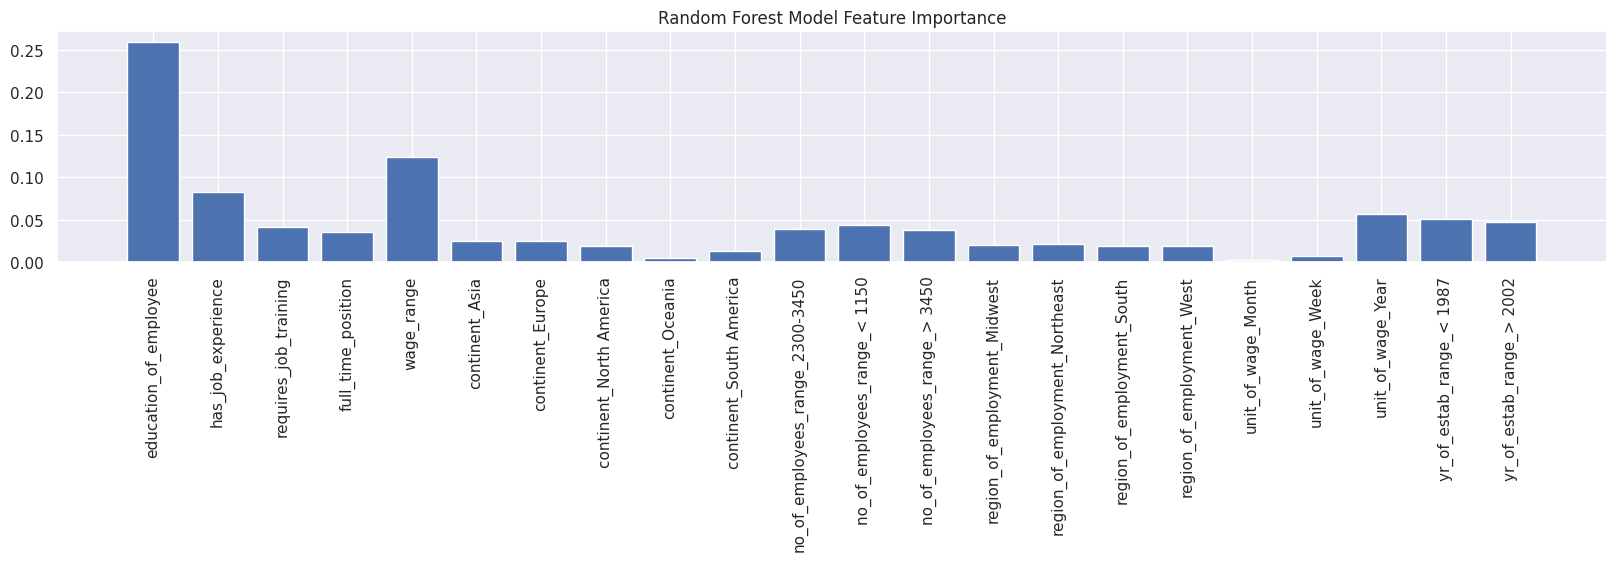

In [21]:
model = RandomForestClassifier()
model.fit(XtrainT, ytrainT)

features = XtrainT.columns.tolist()

feature_df = pd.DataFrame({"Importance":model.feature_importances_,
"Features": features })
sns.set()
plt.rcParams["figure.figsize"] = (20,3)
plt.bar(feature_df["Features"], feature_df["Importance"])
plt.xticks(rotation=90)
plt.title("Random Forest Model Feature Importance")
plt.show()

In [22]:
#Se ordenan las variables en orden de importancia y se genera el listado

sorted_features = feature_df.sort_values(by='Importance', ascending=False)['Features'].tolist()

print("Las variables en orden de importancia aplicando Random Forest son: ")
display(sorted_features)


Las variables en orden de importancia aplicando Random Forest son: 


['education_of_employee',
 'wage_range',
 'has_job_experience',
 'unit_of_wage_Year',
 'yr_of_estab_range_< 1987',
 'yr_of_estab_range_> 2002',
 'no_of_employees_range_< 1150',
 'requires_job_training',
 'no_of_employees_range_2300-3450',
 'no_of_employees_range_> 3450',
 'full_time_position',
 'continent_Europe',
 'continent_Asia',
 'region_of_employment_Northeast',
 'region_of_employment_Midwest',
 'continent_North America',
 'region_of_employment_South',
 'region_of_employment_West',
 'continent_South America',
 'unit_of_wage_Week',
 'continent_Oceania',
 'unit_of_wage_Month']

In [23]:
# Extraemos las primeras 19 variables y las ordenamos alfabéticamente para compararlas con las obtenidas mediante PCA

sorted_features_19 = sorted_features[0:19]
sorted_features_19.sort()
sorted_features_19

['continent_Asia',
 'continent_Europe',
 'continent_North America',
 'continent_South America',
 'education_of_employee',
 'full_time_position',
 'has_job_experience',
 'no_of_employees_range_2300-3450',
 'no_of_employees_range_< 1150',
 'no_of_employees_range_> 3450',
 'region_of_employment_Midwest',
 'region_of_employment_Northeast',
 'region_of_employment_South',
 'region_of_employment_West',
 'requires_job_training',
 'unit_of_wage_Year',
 'wage_range',
 'yr_of_estab_range_< 1987',
 'yr_of_estab_range_> 2002']

##**Como podemos ver, las variables obtenidas mediante Random Forest son casi las mismas que las obtenidas con PCA**

Creamos una lista que combine ambas variables

In [25]:
# Se unifican las listas de las variables obtenidas mediante PCA con las variables obtenidas mediante Random Forest

combined_vars = []
for var in unique_vars:
  if var not in combined_vars:
    combined_vars.append(var)
for var in sorted_features_19:
  if var not in combined_vars:
    combined_vars.append(var)

combined_vars


['continent_Asia',
 'continent_Europe',
 'continent_North America',
 'education_of_employee',
 'full_time_position',
 'has_job_experience',
 'no_of_employees_range_2300-3450',
 'no_of_employees_range_< 1150',
 'no_of_employees_range_> 3450',
 'region_of_employment_Midwest',
 'region_of_employment_Northeast',
 'region_of_employment_South',
 'region_of_employment_West',
 'requires_job_training',
 'unit_of_wage_Week',
 'unit_of_wage_Year',
 'wage_range',
 'yr_of_estab_range_< 1987',
 'yr_of_estab_range_> 2002',
 'continent_South America']

In [26]:
print("El número de variables más significatiivas tanto para el análisis de PCA como para el análisis de Random Forest es: " + str(len(combined_vars)))


El número de variables más significatiivas tanto para el análisis de PCA como para el análisis de Random Forest es: 20


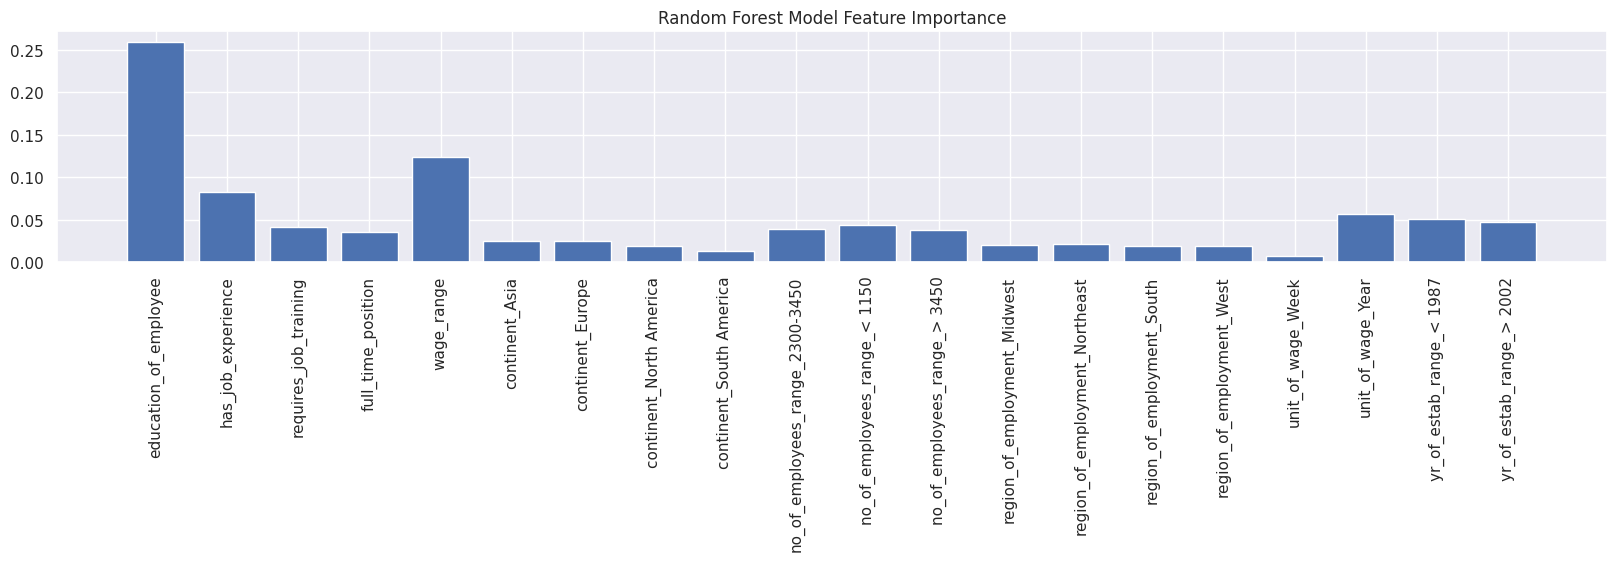

In [27]:
# Se crea un dataframe con los resultados del análisis de Random Forest que contenga solamente las variables de la lista anterior

feature_df_copy = feature_df.copy()

filtered_feature_df = feature_df_copy[feature_df_copy['Features'].isin(combined_vars)]

# Se grafica el nuevo dataframe
sns.set()
plt.rcParams["figure.figsize"] = (20,3)
plt.bar(filtered_feature_df["Features"], filtered_feature_df["Importance"])
plt.xticks(rotation=90)
plt.title("Random Forest Model Feature Importance")
plt.show()


Como se puede observar en la gráfica, de las variables más significativas son 'education_of_employee', 'wage_range' y 'has_job_experience'

#**Parte 3: Análisis mediante el cirterio de selección de factores por importancia de los mismos empleando Regresión Logística como estimador**

In [28]:
# Indicamos el modelo que se usará para evaluar la importancia de los factores

fs = SelectFromModel(estimator=LogisticRegression(), max_features=None)

# ajustamos con  los datos de entrenamiento para determinar cuáles se consideran los más relevantes:
fs.fit(XtrainT, np.ravel(ytrainT))

# y ahora obtenemos los factores
factor_select = fs.get_support(indices=True)

# Incorporamos los factores a una lista
selected_features_3 = [features[i] for i in factor_select]

print(f"The {len(selected_features_3)} Features selected by SelectFromModel: {sorted(selected_features_3)}")

The 9 Features selected by SelectFromModel: ['continent_Europe', 'continent_South America', 'education_of_employee', 'has_job_experience', 'region_of_employment_Midwest', 'region_of_employment_South', 'unit_of_wage_Month', 'unit_of_wage_Week', 'unit_of_wage_Year']


## Como se puede ver, la mayoría de las variables obtenidas mediante este análisis con Regresión Logística, ya se encuentran en la lista obtenida previamente mediante PCA y Random Forest

In [29]:
# Creamos un set de las variables combinadas
combined_set = set(combined_vars)

# Iteramos en la lista 'selected_features_3' para agregar los elementos que no se encuentran en el set de variables combinadas
for feature in selected_features_3:
  if feature not in combined_set:
    combined_vars.append(feature)

# Convertimos la lista combined_vars a set (para remover duplicados) y lo convertimos nuevamente a lista
combined_vars = list(set(combined_vars))

# Se imprimie la lista combinada con variables únicos
print(f"La lista combinada con variable úncias es: {sorted(combined_vars)}")


La lista combinada con variable úncias es: ['continent_Asia', 'continent_Europe', 'continent_North America', 'continent_South America', 'education_of_employee', 'full_time_position', 'has_job_experience', 'no_of_employees_range_2300-3450', 'no_of_employees_range_< 1150', 'no_of_employees_range_> 3450', 'region_of_employment_Midwest', 'region_of_employment_Northeast', 'region_of_employment_South', 'region_of_employment_West', 'requires_job_training', 'unit_of_wage_Month', 'unit_of_wage_Week', 'unit_of_wage_Year', 'wage_range', 'yr_of_estab_range_< 1987', 'yr_of_estab_range_> 2002']


In [30]:
print("El número de variables más significatiivas tanto para el análisis de PCA como para el análisis de Random Forest y Regresión Logística es: " + str(len(combined_vars)))

El número de variables más significatiivas tanto para el análisis de PCA como para el análisis de Random Forest y Regresión Logística es: 21


##**Parte 4. Importancia de los factores mediante el Factor de Inflación de la Varianza (VIF)**

##Mediante el análisis de VIF se pretende detectar si existe multicolinealidad entre las variables hasta ahora seleccionadas, para eliminar de la lista aquellas que las que se detecte un alto índice de multicolinealidad (mayor a 10).

##Esto se hace calculando el índice VIF para cada variable y eliminando del dataframe la variable con mayor índice VIF (si es mayor a 10). A continuación, se calcula nuevamente el índice VIF para todas las variables y se elimina nuevamente la de mayor índice VIF (si es mayor a 10).

##Este proceso se repite hasta que el índice VIF de la variable con mayor índice VIF sea menor a 10.

In [31]:
# Definimos una función para estar evaluando el índice VIF:


def indice_vif(X):

    X = pd.DataFrame(X)  # nos aseguramos que las variable de entrada están en un DataFrame de Pandas.
    vif = pd.DataFrame()   # inicializamos el DataFRame de vif
    vif["factores"] = X.columns   # recuperamos todos los factores de nuestro conjunto de entrada
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]  # FOR sobre las columnas/factores de X.

    return(vif)

In [32]:

# Creamos un nuevo dataframe que solamente contega las columnas de la lista 'combined_vars'
new_dataframe = XtrainT[combined_vars]

# Verificamos el dataframe
print(new_dataframe.head())


       unit_of_wage_Year  region_of_employment_Midwest  education_of_employee  \
9036                   0                             0               0.458579   
21818                  1                             0               0.458579   
18343                  1                             0               1.000000   
12820                  1                             0               0.458579   
21719                  1                             0               0.458579   

       yr_of_estab_range_> 2002  has_job_experience  unit_of_wage_Week  \
9036                          0                   0                  0   
21818                         0                   0                  0   
18343                         1                   1                  0   
12820                         1                   0                  0   
21719                         1                   1                  0   

       region_of_employment_West  yr_of_estab_range_< 1987  continen

In [33]:
# Obtenemos el índice VIF para cada columna/factor del dataframe

indice_vif(new_dataframe)

,factores,VIF
0,unit_of_wage_Year,11.449996
1,region_of_employment_Midwest,7.218925
2,education_of_employee,5.070196
3,yr_of_estab_range_> 2002,2.063630
4,has_job_experience,2.505753
5,unit_of_wage_Week,1.126309
6,region_of_employment_West,10.332761
7,yr_of_estab_range_< 1987,2.068977
8,continent_Europe,4.983212
9,no_of_employees_range_2300-3450,1.756118


In [34]:

# Removemos permanentemente la columna 'continent_Asia'

new_dataframe = new_dataframe.drop('continent_Asia', axis=1)

indice_vif(new_dataframe)


,factores,VIF
0,unit_of_wage_Year,11.097350
1,region_of_employment_Midwest,5.232407
2,education_of_employee,5.041353
3,yr_of_estab_range_> 2002,2.053818
4,has_job_experience,2.504562
5,unit_of_wage_Week,1.123832
6,region_of_employment_West,7.354747
7,yr_of_estab_range_< 1987,2.060377
8,continent_Europe,1.305725
9,no_of_employees_range_2300-3450,1.752092


In [35]:
# Removemos permanentemente la columna 'unit_of_wage_Year'

new_dataframe = new_dataframe.drop('unit_of_wage_Year', axis=1)

indice_vif(new_dataframe)

,factores,VIF
0,region_of_employment_Midwest,4.006204
1,education_of_employee,4.958667
2,yr_of_estab_range_> 2002,2.044473
3,has_job_experience,2.424033
4,unit_of_wage_Week,1.017605
5,region_of_employment_West,5.742501
6,yr_of_estab_range_< 1987,2.058891
7,continent_Europe,1.302476
8,no_of_employees_range_2300-3450,1.742847
9,continent_North America,1.193151


In [36]:
# Creamos una lista con los nombres de las columnas que aún quedan en el dataframe

final_features_list = new_dataframe.columns.tolist()
final_features_list


['region_of_employment_Midwest',
 'education_of_employee',
 'yr_of_estab_range_> 2002',
 'has_job_experience',
 'unit_of_wage_Week',
 'region_of_employment_West',
 'yr_of_estab_range_< 1987',
 'continent_Europe',
 'no_of_employees_range_2300-3450',
 'continent_North America',
 'no_of_employees_range_< 1150',
 'no_of_employees_range_> 3450',
 'continent_South America',
 'full_time_position',
 'region_of_employment_Northeast',
 'requires_job_training',
 'wage_range',
 'unit_of_wage_Month',
 'region_of_employment_South']

In [37]:
print("El número de variables despúes de remover las de índice VIF mayor a 10 es: " + str(len(final_features_list)))

El número de variables despúes de remover las de índice VIF mayor a 10 es: 19


In [93]:
# Creamos tres nuevos dataframes de entrenamiento, validación y prueba que contengan solamente las variables que aparecen en 'final_features_list'
XtrainT_reduc = XtrainT[final_features_list]
XvalT_reduc = XvalT[final_features_list]
XtestT_reduc = XtestT[final_features_list]

# Varificamos los dataframes
print(XtrainT_reduc.head())
print(XvalT_reduc.head())
print(XtestT_reduc.head())


       region_of_employment_Midwest  education_of_employee  \
9036                              0               0.458579   
21818                             0               0.458579   
18343                             0               1.000000   
12820                             0               0.458579   
21719                             0               0.458579   

       yr_of_estab_range_> 2002  has_job_experience  unit_of_wage_Week  \
9036                          0                   0                  0   
21818                         0                   0                  0   
18343                         1                   1                  0   
12820                         1                   0                  0   
21719                         1                   1                  0   

       region_of_employment_West  yr_of_estab_range_< 1987  continent_Europe  \
9036                           0                         0                 0   
21818                 

##**Generamos un modelo preliminar de predicciones con XGBOOST**

##**Este modelo se utilizará como base para determinar si se pueden eliminar otras variables sin disminuír la capacidad de predicción del modelo**

In [94]:
from sklearn.model_selection import cross_validate # Importing cross_validate function
from imblearn.pipeline import Pipeline
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Function to clean column names (Xgboost no acepta los símbolos de  > y < para los nombres de sus columnas)
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = col.replace('[', '').replace(']', '').replace('<', 'lt').replace('>', 'mt')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Clean the column names in the dataframes
XtrainT_reduc = clean_col_names(XtrainT_reduc)
XvalT_reduc = clean_col_names(XvalT_reduc)
XtestT_reduc = clean_col_names(XtestT_reduc)


pipe = Pipeline(steps=[
                       #('rus', RandomUnderSampler(random_state=99)),
                       #('standardscaler', StandardScaler()),
                       ('xgb', XGBClassifier(eta=0.1, gamma=3, max_depth=15, enable_categorical=True,
                          # tree_method='gpu_hist',  # Comment out this line to disable GPU usage
                          n_estimators=40,
                          reg_alpha=0.001, validate_parameters=True))])

pipe.fit(XtrainT_reduc, ytrainT) # Assuming XtrainT_reduc is the correct variable

# Calling cross_validate with correct variable name
cross_validate(pipe, XtrainT_reduc, ytrainT) # Changed XtrainT_reduc_ to XtrainT_reduc

{'fit_time': array([0.11897111, 0.12262082, 0.12723756, 0.12967706, 0.12694788]),
 'score_time': array([0.01542592, 0.01701331, 0.01547194, 0.01696324, 0.01693988]),
 'test_score': array([0.74159193, 0.73451079, 0.745164  , 0.72890384, 0.74348192])}

In [95]:
pred_pipe = pipe.predict(XvalT_reduc)

In [96]:
print(classification_report(yvalT, pred_pipe))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      2553
           1       0.63      0.46      0.53      1269

    accuracy                           0.73      3822
   macro avg       0.70      0.66      0.67      3822
weighted avg       0.72      0.73      0.72      3822



In [97]:
# Desplegando la matriz de confusión:
# (etiquetas_reales, etiquetas_de_predicciones)
def mi_cm(yreal, ypred):
  cm = confusion_matrix(yreal, ypred)
  frecs = cm.flatten()

  txt = ['Verdaderos Negativos','Falsos Positivos','Falsos Negativos','Verdaderos Positivos']
  vf = [ '( VN )', '( FP )', '( FN )', '( VP )']
  frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
  porcentaje = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]
  porcentaje_por_categoría = [frecs[0]/(frecs[0]+frecs[1]),
                              frecs[1]/(frecs[0]+frecs[1]),
                              frecs[2]/(frecs[2]+frecs[3]),
                              frecs[3]/(frecs[2]+frecs[3])]
  porcentaje_por_categoría = ['{0:.1%}'.format(value) for value in porcentaje_por_categoría]

  labels = [f"{v1}\n{v2}\n{v3}\n{v4}\n{v5}" for v1, v2, v3, v4, v5 in zip(txt,vf, frecuencia,porcentaje,porcentaje_por_categoría)]
  labels = np.asarray(labels).reshape(2,2)

  plt.figure(figsize=(6,4))
  ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Pastel1', cbar=False)
  ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
  plt.show()

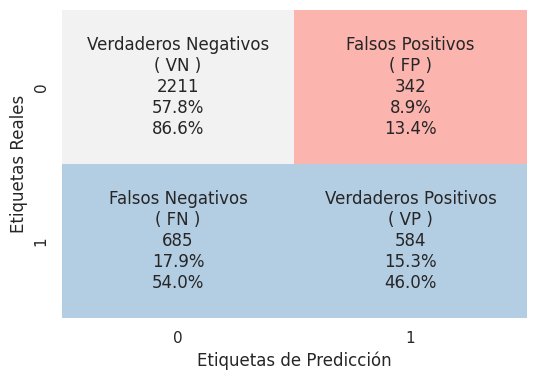

None


In [98]:
print(mi_cm(yvalT,pred_pipe))

In [99]:
pred_pipe = pipe.predict(XtestT_reduc)

In [100]:
print(classification_report(ytestT, pred_pipe))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      2553
           1       0.67      0.49      0.57      1269

    accuracy                           0.75      3822
   macro avg       0.73      0.69      0.70      3822
weighted avg       0.74      0.75      0.74      3822



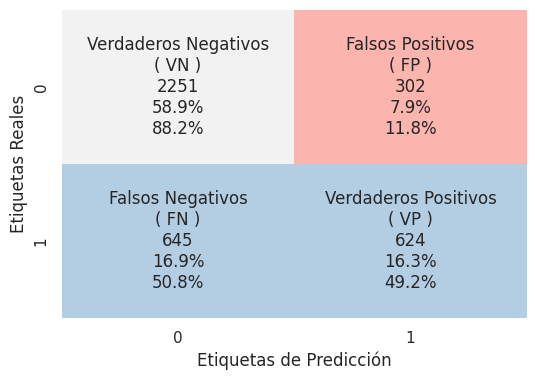

None


In [101]:
print(mi_cm(ytestT,pred_pipe))

##**Parte 5. Reducción de dimensionalidad mdiante la aplicación de  Importancia de Permutaciones (Permutation Importance) y Autoencoders**

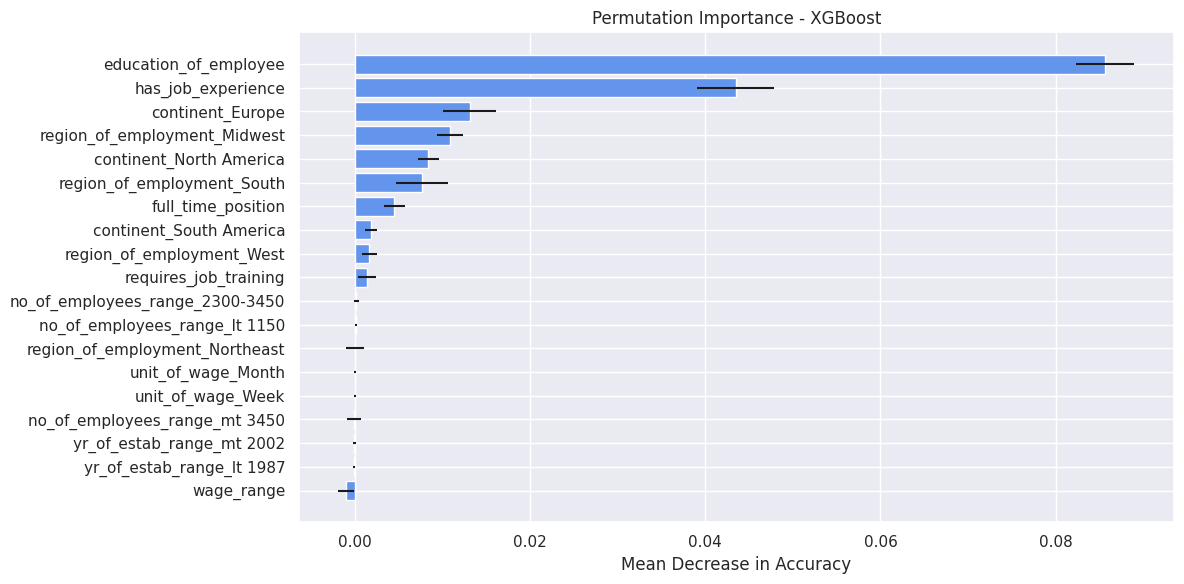

In [102]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Entrena el pipeline
pipe.fit(XtrainT_reduc, ytrainT)

# Aplica Permutation Importance en el conjunto de validación
result = permutation_importance(pipe, XvalT_reduc, yvalT, n_repeats=10, random_state=42, n_jobs=-1)

# Crea un DataFrame con los resultados
feature_names = XtrainT_reduc.columns  # Asegúrate que XtrainT_reduc sea un DataFrame
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
})

# Ordena por importancia
importances_df = importances_df.sort_values(by='Importance Mean', ascending=False)

# Muestra los resultados
plt.figure(figsize=(12, 6))
plt.barh(importances_df['Feature'], importances_df['Importance Mean'], xerr=importances_df['Importance Std'], color='cornflowerblue')
plt.gca().invert_yaxis()
plt.xlabel("Mean Decrease in Accuracy")
plt.title("Permutation Importance - XGBoost")
plt.tight_layout()
plt.show()


el modelo tiene muchas vairables com muy pocos elementos  que tienen una importacia positiva, vamos a fitrar aquellas que tengan un valor mayor a 0.001

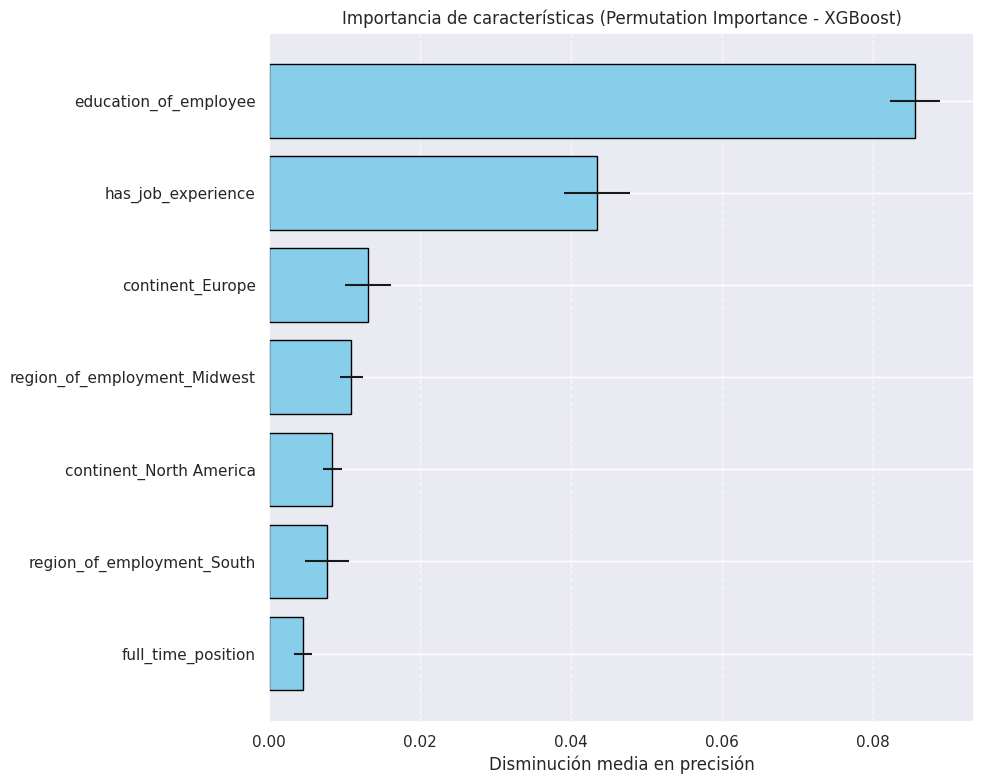

In [103]:
# Filtra solo las características con importancia positiva
importances_df_filtered = importances_df[importances_df['Importance Mean'] > 0.003]

# Ordena de nuevo
importances_df_filtered = importances_df_filtered.sort_values(by='Importance Mean', ascending=True)

# Grafico mejorado
plt.figure(figsize=(10, 8))
plt.barh(importances_df_filtered['Feature'], importances_df_filtered['Importance Mean'],
         xerr=importances_df_filtered['Importance Std'], color='skyblue', edgecolor='black')
plt.xlabel("Disminución media en precisión")
plt.title("Importancia de características (Permutation Importance - XGBoost)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Ejecutamos nuevamente el modelo XGBoost tomando en cuenta solamente las 7 variables anteriores, para determinar si el modelo no pierde capacidad de predicción

In [104]:
list_7_vars = importances_df_filtered['Feature'].tolist()
list_7_vars

['full_time_position',
 'region_of_employment_South',
 'continent_North America',
 'region_of_employment_Midwest',
 'continent_Europe',
 'has_job_experience',
 'education_of_employee']

In [105]:
# Keep only the column names that appear in list_7_vars in the dataframes XtrainT_reduc, XvalT_reduc, and XtestT_reduc

XtrainT_reduc = XtrainT_reduc[list_7_vars]
XvalT_reduc = XvalT_reduc[list_7_vars]
XtestT_reduc = XtestT_reduc[list_7_vars]

# Verify the dataframes
print("XtrainT_reduc after reduction:")
print(XtrainT_reduc.head())
print("\nXvalT_reduc after reduction:")
print(XvalT_reduc.head())
print("\nXtestT_reduc after reduction:")
print(XtestT_reduc.head())

XtrainT_reduc after reduction:
       full_time_position  region_of_employment_South  \
9036                    1                           0   
21818                   1                           0   
18343                   1                           0   
12820                   1                           0   
21719                   1                           1   

       continent_North America  region_of_employment_Midwest  \
9036                         0                             0   
21818                        0                             0   
18343                        0                             0   
12820                        0                             0   
21719                        0                             0   

       continent_Europe  has_job_experience  education_of_employee  
9036                  0                   0               0.458579  
21818                 0                   0               0.458579  
18343                 1           

In [106]:
# Train the model with the reduced dataframes

pipe = Pipeline(steps=[
                       #('rus', RandomUnderSampler(random_state=99)),
                       #('standardscaler', StandardScaler()),
                       ('xgb', XGBClassifier(eta=0.1, gamma=3, max_depth=15, enable_categorical=True,
                          # tree_method='gpu_hist',  # Comment out this line to disable GPU usage
                          n_estimators=40,
                          reg_alpha=0.001, validate_parameters=True))])

pipe.fit(XtrainT_reduc, ytrainT) # Assuming XtrainT_reduc is the correct variable

# Calling cross_validate with correct variable name
cross_validate(pipe, XtrainT_reduc, ytrainT) # Changed XtrainT_reduc_ to XtrainT_reduc

{'fit_time': array([0.08039737, 0.08687568, 0.0974462 , 0.08053589, 0.07742596]),
 'score_time': array([0.01216149, 0.01235723, 0.01344776, 0.01054144, 0.0113976 ]),
 'test_score': array([0.73710762, 0.73310906, 0.74208018, 0.72301654, 0.74376227])}

In [107]:
pred_pipe = pipe.predict(XvalT_reduc)

In [108]:
print(classification_report(yvalT, pred_pipe))

              precision    recall  f1-score   support

           0       0.76      0.88      0.81      2553
           1       0.64      0.43      0.52      1269

    accuracy                           0.73      3822
   macro avg       0.70      0.66      0.67      3822
weighted avg       0.72      0.73      0.71      3822



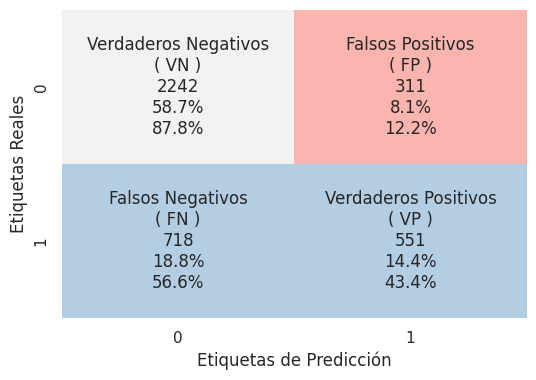

None


In [109]:
print(mi_cm(yvalT,pred_pipe))

In [110]:
pred_pipe = pipe.predict(XtestT_reduc)

In [111]:
print(classification_report(ytestT, pred_pipe))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      2553
           1       0.68      0.45      0.55      1269

    accuracy                           0.75      3822
   macro avg       0.72      0.67      0.69      3822
weighted avg       0.74      0.75      0.73      3822



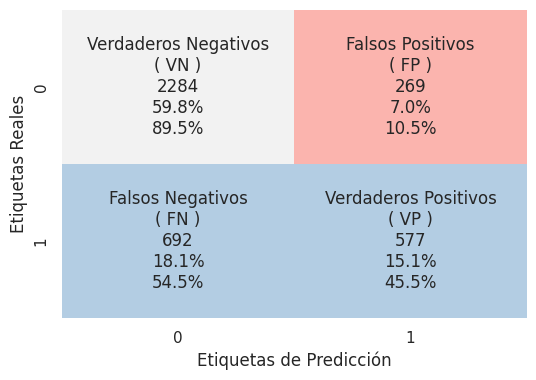

None


In [112]:
print(mi_cm(ytestT,pred_pipe))

#**Como se puede ver, al reducir el modelo a 7 variables se mantiene prácticamente la misma capacidad de predicción**

**Sin embargo, el modelo predice correctamente el 89.5% de los casos negativos, pero solo el 45.5% de los casos positivos, por lo que se debe ajustar o buscar otro modelo**

##**Entrenaremos un modelo con el algoritmo QuadraticDiscriminantAnalysis ajustando los pesos de cada clase para incrementar el porcentaje de verdaderos positivos**

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Text(0.5, 1.0, 'Score para diferntes pesos asignados a la clase 0')

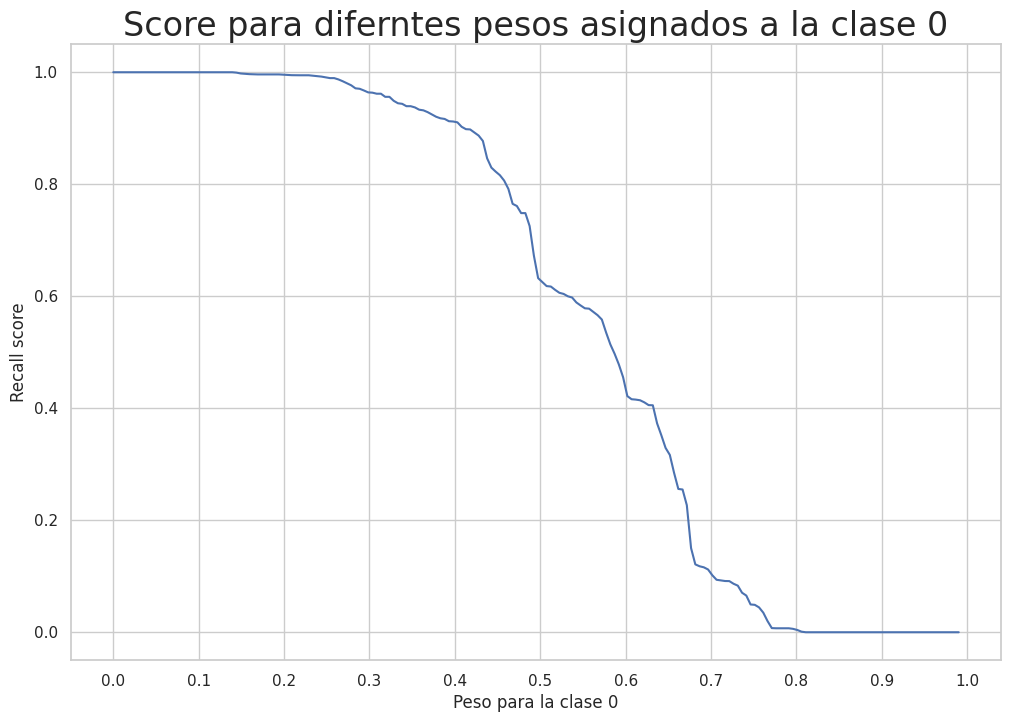

In [115]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold

def c1_recall_scorer(y_true, y_pred):


  cm = confusion_matrix(y_true, y_pred)


  tn, fp, fn, tp = cm.ravel()


  if (tp + fn) == 0:
      return 0.0
  else:
      return tp / (tp + fn)



qda_estimator = QuadraticDiscriminantAnalysis()

x_train_data = XtrainT_reduc
y_train_data = np.ravel(ytrainT)

weights = np.linspace(0.0,0.99,200)


param_grid = {'priors': [[x, 1.0-x] for x in weights],
               'reg_param' : [0.1]

              }

recall_c1_scorer = make_scorer(c1_recall_scorer)

gridsearch = GridSearchCV(estimator= qda_estimator,
                          param_grid= param_grid,
                          cv=StratifiedKFold(),
                          n_jobs=-1,
                          scoring=recall_c1_scorer,
                          verbose=2).fit(x_train_data, y_train_data)


sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': ( weights)})
sns.lineplot(x=weigh_data['weight'], y=weigh_data['score'])
plt.xlabel('Peso para la clase 0')
plt.ylabel('Recall score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Score para diferntes pesos asignados a la clase 0', fontsize=24)

In [116]:
import numpy as np
best_score_index = np.argmax(gridsearch.cv_results_['mean_test_score'])
best_weight = weights[best_score_index]

print(f"Para obtener el máximo F1 score, el peso de la clase 0 es: {best_weight} y el peso de la clase 1 es: {1 - best_weight}")

Para obtener el máximo F1 score, el peso de la clase 0 es: 0.0 y el peso de la clase 1 es: 1.0


In [150]:
# Ajuste de hiperparámetros para RFC con Class Weigth -asignando pesos

w0 = 0.48
w1 = 1 -w0

pipe_qda_cwc = Pipeline(steps=[

                                ('qda_cwc' , QuadraticDiscriminantAnalysis(
                                              priors= [w0, w1],
                                              reg_param = 0.1
                                              ))

                              ])

x_train_data = XtrainT_reduc
y_train_data = np.ravel(ytrainT)

pipe_qda_cwc.fit(x_train_data, y_train_data)

# Se emplea validación cruzada con stratified k fold puesto que las clases están imbalanceadas

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(pipe_qda_cwc, x_train_data, y_train_data, cv=stratified_cv)

print(cv_results)

{'fit_time': array([0.0108397 , 0.04032469, 0.01869774, 0.03165126, 0.0261848 ]), 'score_time': array([0.00446463, 0.00427008, 0.00869656, 0.0118885 , 0.00436521]), 'test_score': array([0.65442825, 0.64087468, 0.63779086, 0.64255677, 0.65349033])}


------Resultados para el modelo Quadratic Discriminant Analysis con Pesos en las Clases------


-----Resultados para el conjunto de validación-----
              precision    recall  f1-score   support

           0       0.84      0.58      0.69      2553
           1       0.48      0.77      0.59      1269

    accuracy                           0.65      3822
   macro avg       0.66      0.68      0.64      3822
weighted avg       0.72      0.65      0.66      3822



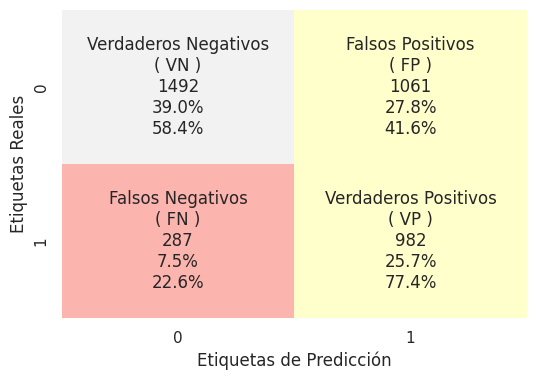

None


-----Resultados para el conjunto de prueba-----
              precision    recall  f1-score   support

           0       0.85      0.59      0.70      2553
           1       0.49      0.80      0.61      1269

    accuracy                           0.66      3822
   macro avg       0.67      0.69      0.65      3822
weighted avg       0.73      0.66      0.67      3822



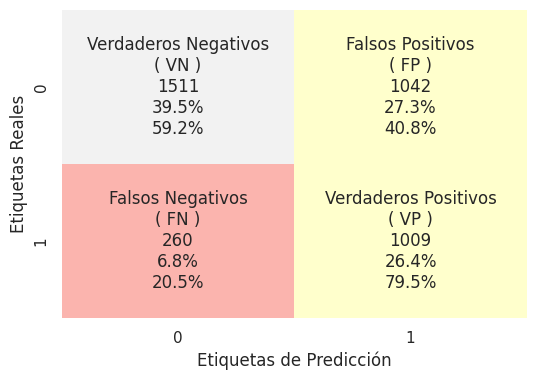

None


In [151]:

lista_modelo = [pipe_qda_cwc, 'Quadratic Discriminant Analysis con Pesos en las Clases']



print("------Resultados para el modelo " + lista_modelo[1] + "------")

# Se obtienen las probabilidades utilizando el threshold
y_pred_proba = lista_modelo[0].predict(XvalT_reduc)

y_pred = (y_pred_proba)

print("\n\n-----Resultados para el conjunto de validación-----")

print(classification_report(yvalT, y_pred))

print(mi_cm(yvalT,y_pred))

print("\n\n-----Resultados para el conjunto de prueba-----")

y_pred_proba = lista_modelo[0].predict(XtestT_reduc)

y_pred = (y_pred_proba)

print(classification_report(ytestT, y_pred))

print(mi_cm(ytestT,y_pred))

##**Con este modelo se obtiene predicen correctamente el 79.5% de los casos positivos y el 59.2% de los casos negativos, pero ya se puede utilizar para desarrollar un MVP. Posteriormente se deberá ir mejorando el modelo aplicando técnicas de ensamble (stacking) para mejorar las predicciones**